In [1]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import (confusion_matrix, f1_score, recall_score, precision_score, 
                            accuracy_score, roc_curve, auc, roc_auc_score, 
                            log_loss, brier_score_loss, classification_report,
                            precision_recall_fscore_support)
from sklearn.calibration import CalibratedClassifierCV
import xgboost as xgb
import shap




In [20]:
# Parse CSV and Basic Data

df = pd.read_csv('shots_2007-2023.csv')

print(f"Dataset Shape: {df.shape}")
print(df.head())

print(f"\nTarget variable 'goal' distribution:\n{df['goal'].value_counts()}")
print(f"Goal rate: {df['goal'].mean():.4f}")


Dataset Shape: (1840218, 124)
   shotID homeTeamCode awayTeamCode  season  isPlayoffGame  game_id  \
0       0          TBL          NSH    2023              0    20001   
1       1          TBL          NSH    2023              0    20001   
2       2          TBL          NSH    2023              0    20001   
3       3          TBL          NSH    2023              0    20001   
4       4          TBL          NSH    2023              0    20001   

   homeTeamWon  id  time  timeUntilNextEvent  ...    xFroze  xRebound  \
0            1  10    61                 9.0  ...  0.249174  0.035816   
1            1  11    70                26.0  ...  0.107945  0.051284   
2            1  13   107                 2.0  ...  0.236193  0.030269   
3            1  19   177                35.0  ...  0.198635  0.033686   
4            1  21   231                29.0  ...  0.188582  0.027146   

  xPlayContinuedInZone xPlayContinuedOutsideZone xPlayStopped  xShotWasOnGoal  \
0             0.379310 

In [21]:
# Remove Bad Rows

print(df.describe())
print(f"\nData Types:\n{df.dtypes}")

missing_data = df.isnull().sum()
print(f"\nMissing values: {missing_data.sum()}")
if missing_data.sum() > 0:
    df = df.dropna()

print(f"Duplicates: {df.duplicated().sum()}")
if df.duplicated().sum() > 0:
    df = df.drop_duplicates()

before = df.shape[0]

# 1. Remove neutral zone shots
df = df[df["location"] != "Neu. Zone"]

non_neutral_zone_shots = df.shape[0]

print(f"Shots from netural zone: {before - non_neutral_zone_shots}")

# 2. Remove shots taken from a team's own zone
df = df[
    df["location"].str[:4].str.lower() != df["team"].str[:4].str.lower()
]

shots_from_offensive_zone = df.shape[0]

print("Shots from own zone: ", non_neutral_zone_shots - shots_from_offensive_zone)

# 3. Remove shots where lastEventTeam is Neither "HOME" no "AWAY"

# Normalize Upper-case and trimmed
df["lastEventTeam"] = (
    df["lastEventTeam"]
    .astype(str)
    .str.upper()
    .str.strip()
)

# Keep only rows where lastEventTeam is HOME or AWAY
df = df[df["lastEventTeam"].isin(["HOME", "AWAY"])]

print("Shots with invalid previous event data: ", shots_from_offensive_zone - df.shape[0])

             shotID        season  isPlayoffGame       game_id   homeTeamWon  \
count  1.840218e+06  1.840218e+06   1.840218e+06  1.840218e+06  1.840218e+06   
mean   9.201085e+05  2.015146e+03   7.252782e-02  2.130252e+04  5.417787e-01   
std    5.312253e+05  4.960793e+00   2.593599e-01  2.513023e+03  4.982516e-01   
min    0.000000e+00  2.007000e+03   0.000000e+00  2.000100e+04  0.000000e+00   
25%    4.600542e+05  2.011000e+03   0.000000e+00  2.032200e+04  0.000000e+00   
50%    9.201085e+05  2.015000e+03   0.000000e+00  2.064400e+04  1.000000e+00   
75%    1.380163e+06  2.019000e+03   0.000000e+00  2.098600e+04  1.000000e+00   
max    1.840217e+06  2.023000e+03   1.000000e+00  3.041700e+04  1.000000e+00   

                 id          time  timeUntilNextEvent  timeSinceLastEvent  \
count  1.840218e+06  1.840218e+06        1.840218e+06        1.840218e+06   
mean   1.607135e+02  1.835555e+03        1.145011e+01        1.570407e+01   
std    9.231472e+01  1.058338e+03        1.49593

In [22]:
#Feature Engineering

# How many more players the offensive team has than the defensive team
df["skaterAdvantage"] = np.where(
    df["team"] == "HOME",
    df["homeSkatersOnIce"] - df["awaySkatersOnIce"],
    df["awaySkatersOnIce"] - df["homeSkatersOnIce"]
)

# Weather the last event was offensive or defensive
df["lastEventOffensive"] = np.where(
    df["lastEventTeam"] == df["team"],
    1,
    0
)

# Some general shot location info

# Low Slot = close + central
df["isLowSlot"] = (
    (df["arenaAdjustedShotDistance"] <= 15) &
    (df["shotAngleAdjusted"] <= 22.5)
).astype(int)

# High Slot = mid range + central-ish
df["isHighSlot"] = (
    (df["arenaAdjustedShotDistance"].between(15, 30)) &
    (df["shotAngleAdjusted"] <= 30)
).astype(int)

# Shot from far away
df["isPointShot"] = (df["arenaAdjustedShotDistance"] > 40).astype(int)

# Shot from an oblique angle
df["isBadAngle"] = (df["shotAngleAdjusted"] >= 60).astype(int)

# Quick release
df["quickRelease"] = (df["timeSinceLastEvent"] <= 1).astype(int)

# Artificial number, but represents interaction between how far the shot is from the net and how oblique the angle is
df["angleDistanceInteraction"] = df["shotAngleAdjusted"] * df["arenaAdjustedShotDistance"]

# Highlights juicy rebounds (low slot)
df["isDangerousRebound"] = (
    (df["shotRebound"] == 1)
    & (df["isLowSlot"] == 1)
).astype(int)


In [25]:
# Hand selected features for model based on domain knowledge

# This stores goals as just a stream of zeroes and ones (used later)
y = df["goal"]

columns_to_keep = [
    "timeSinceLastEvent",
    "team",
    "arenaAdjustedXCordABS",
    "arenaAdjustedYCordAbs",
    "shotAngleAdjusted",
    "arenaAdjustedShotDistance",
    "shotType",
    "shotOnEmptyNet",
    "shotRebound",
    "shotAnglePlusRebound",
    "shotAnglePlusReboundSpeed",
    "shotAngleReboundRoyalRoad",
    "shotRush",
    "speedFromLastEvent",
    "distanceFromLastEvent",
    "lastEventShotAngle",
    "lastEventShotDistance",
    "lastEventCategory",
    "timeSinceFaceoff",
    "shooterLeftRight",
    "shooterTimeOnIce",
    "shooterTimeOnIceSinceFaceoff",
    "offWing",
    "averageRestDifference",
    "skaterAdvantage",
    "lastEventOffensive",
    "isLowSlot",
    "isHighSlot",
    "isPointShot",
    "isBadAngle",
    "quickRelease",
    "angleDistanceInteraction",
    "isDangerousRebound"
]

X = df[columns_to_keep]

In [26]:
# One-Hot Encoding
print(X.columns.tolist())

X = pd.get_dummies(
    X,
    columns=["shooterLeftRight", "shotType", "lastEventCategory"],
    prefix=["hand", "shot", "lastEvent"],
    drop_first=False
)

X = pd.get_dummies(
    X,
    columns=["team", ],
    prefix=["is"],
    drop_first=True 
)

#Turn them into 1/0 values instead of T/F
bool_cols = X.select_dtypes(include="bool").columns
X[bool_cols] = X[bool_cols].astype(int)

print(X.columns.tolist())

['timeSinceLastEvent', 'team', 'arenaAdjustedXCordABS', 'arenaAdjustedYCordAbs', 'shotAngleAdjusted', 'arenaAdjustedShotDistance', 'shotType', 'shotOnEmptyNet', 'shotRebound', 'shotAnglePlusRebound', 'shotAnglePlusReboundSpeed', 'shotAngleReboundRoyalRoad', 'shotRush', 'speedFromLastEvent', 'distanceFromLastEvent', 'lastEventShotAngle', 'lastEventShotDistance', 'lastEventCategory', 'timeSinceFaceoff', 'shooterLeftRight', 'shooterTimeOnIce', 'shooterTimeOnIceSinceFaceoff', 'offWing', 'averageRestDifference', 'skaterAdvantage', 'lastEventOffensive', 'isLowSlot', 'isHighSlot', 'isPointShot', 'isBadAngle', 'quickRelease', 'angleDistanceInteraction', 'isDangerousRebound']
['timeSinceLastEvent', 'arenaAdjustedXCordABS', 'arenaAdjustedYCordAbs', 'shotAngleAdjusted', 'arenaAdjustedShotDistance', 'shotOnEmptyNet', 'shotRebound', 'shotAnglePlusRebound', 'shotAnglePlusReboundSpeed', 'shotAngleReboundRoyalRoad', 'shotRush', 'speedFromLastEvent', 'distanceFromLastEvent', 'lastEventShotAngle', 'last

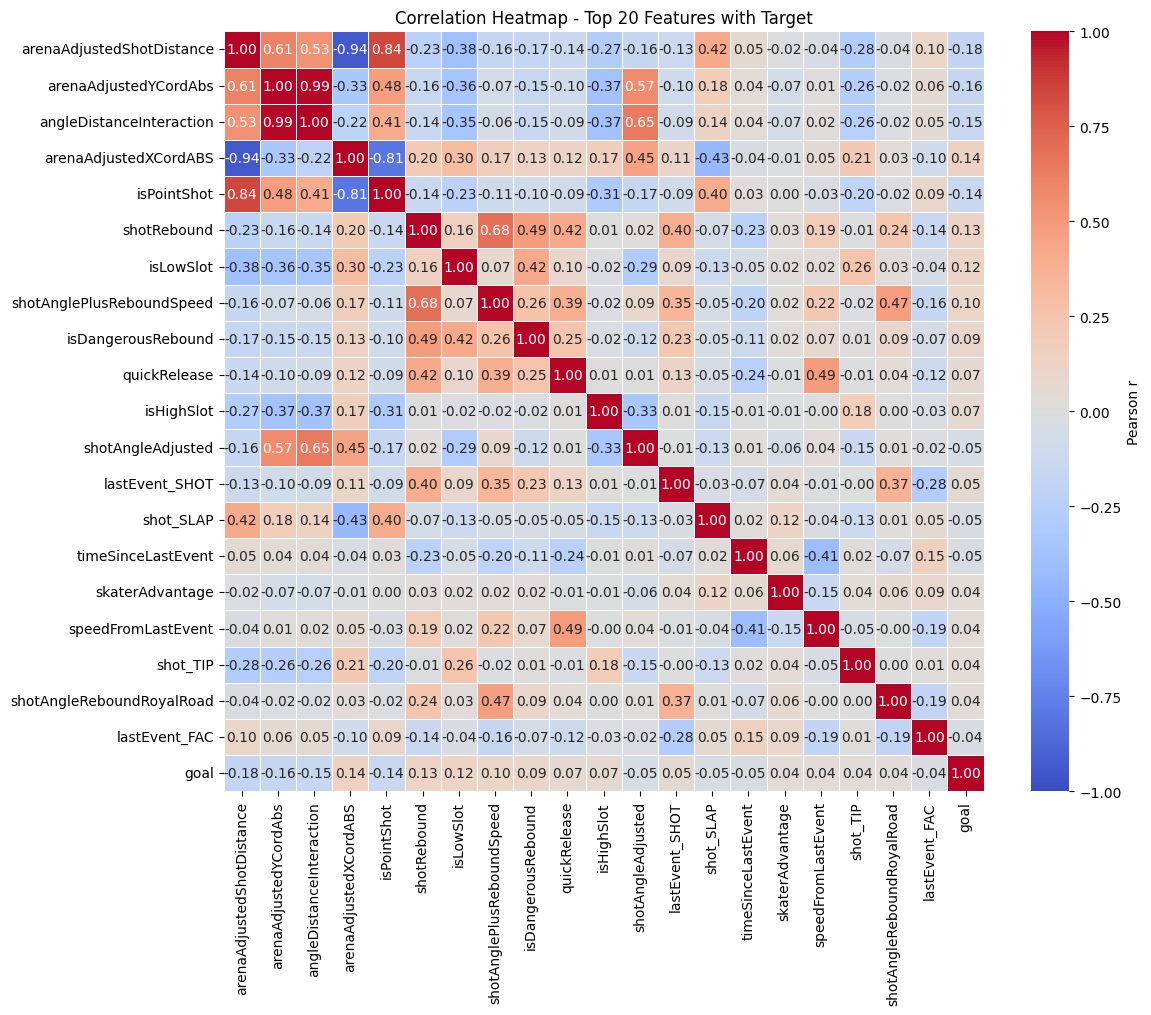

Top features correlated with target:
arenaAdjustedShotDistance    0.177212
arenaAdjustedYCordAbs        0.157150
angleDistanceInteraction     0.151808
arenaAdjustedXCordABS        0.141424
isPointShot                  0.139111
shotRebound                  0.131461
isLowSlot                    0.120785
shotAnglePlusReboundSpeed    0.104494
isDangerousRebound           0.093639
quickRelease                 0.068057
Name: goal, dtype: float64


In [27]:
temp_df = pd.concat([X, y], axis=1)
numeric_df = temp_df.select_dtypes(include="number")
correlation_matrix = numeric_df.corr(numeric_only=True)

corr_with_target = correlation_matrix['goal'].drop(labels=['goal']).abs().sort_values(ascending=False)
top_features = corr_with_target.head(20).index.tolist()
top_features.append('goal')

top_corr_matrix = correlation_matrix.loc[top_features, top_features]

plt.figure(figsize=(12, 10))
sns.heatmap(top_corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", 
            vmin=-1, vmax=1, center=0, square=True, cbar_kws={"label": "Pearson r"},
            linewidths=0.5, linecolor='white')
plt.title("Correlation Heatmap - Top 20 Features with Target")
plt.tight_layout()
plt.show()

print("Top features correlated with target:")
print(corr_with_target.head(10))

In [28]:
# Stratification ensures the proportion of classes (goals vs no-goals) is maintained
# across train/val/test splits. For example, if 10% of shots are goals, then each
# split will have approximately 10% goals. This prevents one split from having
# all goals and another having none, which would bias model evaluation.
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=1/3, random_state=42, stratify=y_temp
)

print(f"Training: {X_train.shape[0]}, Validation: {X_val.shape[0]}, Test: {X_test.shape[0]}")
print(f"\nGoal rate verification (should be similar across splits):")
print(f"Train: {y_train.mean():.4f}, Val: {y_val.mean():.4f}, Test: {y_test.mean():.4f}")
print(f"Overall: {y.mean():.4f}")

Training: 1231876, Validation: 351964, Test: 175983

Goal rate verification (should be similar across splits):
Train: 0.0661, Val: 0.0661, Test: 0.0661
Overall: 0.0661


In [29]:
# Verify column alignment
print(f"\nColumn alignment check:")
print(f"Train columns: {len(X_train.columns)}, Val columns: {len(X_val.columns)}, Test columns: {len(X_test.columns)}")
print(f"Train-Val match: {list(X_train.columns) == list(X_val.columns)}")
print(f"Train-Test match: {list(X_train.columns) == list(X_test.columns)}")

if list(X_train.columns) != list(X_val.columns):
    missing_in_val = set(X_train.columns) - set(X_val.columns)
    extra_in_val = set(X_val.columns) - set(X_train.columns)
    print(f"Missing in Val: {missing_in_val}")
    print(f"Extra in Val: {extra_in_val}")

if list(X_train.columns) != list(X_test.columns):
    missing_in_test = set(X_train.columns) - set(X_test.columns)
    extra_in_test = set(X_test.columns) - set(X_train.columns)
    print(f"Missing in Test: {missing_in_test}")
    print(f"Extra in Test: {extra_in_test}")

assert list(X_train.columns) == list(X_val.columns), f"Train and Val columns don't match! Train: {len(X_train.columns)}, Val: {len(X_val.columns)}"
assert list(X_train.columns) == list(X_test.columns), f"Train and Test columns don't match! Train: {len(X_train.columns)}, Test: {len(X_test.columns)}"

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


Column alignment check:
Train columns: 51, Val columns: 51, Test columns: 51
Train-Val match: True
Train-Test match: True


In [30]:

# Goal rate is ~6.61%
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
print(f"Class weights: {class_weight_dict}")
print(f"  Non-goals (class 0): {class_weight_dict[0]:.4f}")
print(f"  Goals (class 1): {class_weight_dict[1]:.4f}")
print(f"  Ratio: {class_weight_dict[1]/class_weight_dict[0]:.2f}x more weight on goals\n")

models = {}
training_times = {}

start_time = time.time()
lr_model = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
lr_model.fit(X_train_scaled, y_train)
training_times['Logistic Regression'] = (time.time() - start_time) * 1000
models['Logistic Regression'] = lr_model

start_time = time.time()

scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
xgb_model = xgb.XGBClassifier(random_state=42, eval_metric='logloss', scale_pos_weight=scale_pos_weight)
xgb_model.fit(X_train_scaled, y_train)
training_times['XGBoost'] = (time.time() - start_time) * 1000
models['XGBoost'] = xgb_model

print("Training times (ms):")
for name, t_time in training_times.items():
    print(f"{name}: {t_time:.2f}")

Class weights: {0: np.float64(0.5353817804105296), 1: np.float64(7.5657834936310815)}
  Non-goals (class 0): 0.5354
  Goals (class 1): 7.5658
  Ratio: 14.13x more weight on goals

Training times (ms):
Logistic Regression: 4563.41
XGBoost: 3149.92


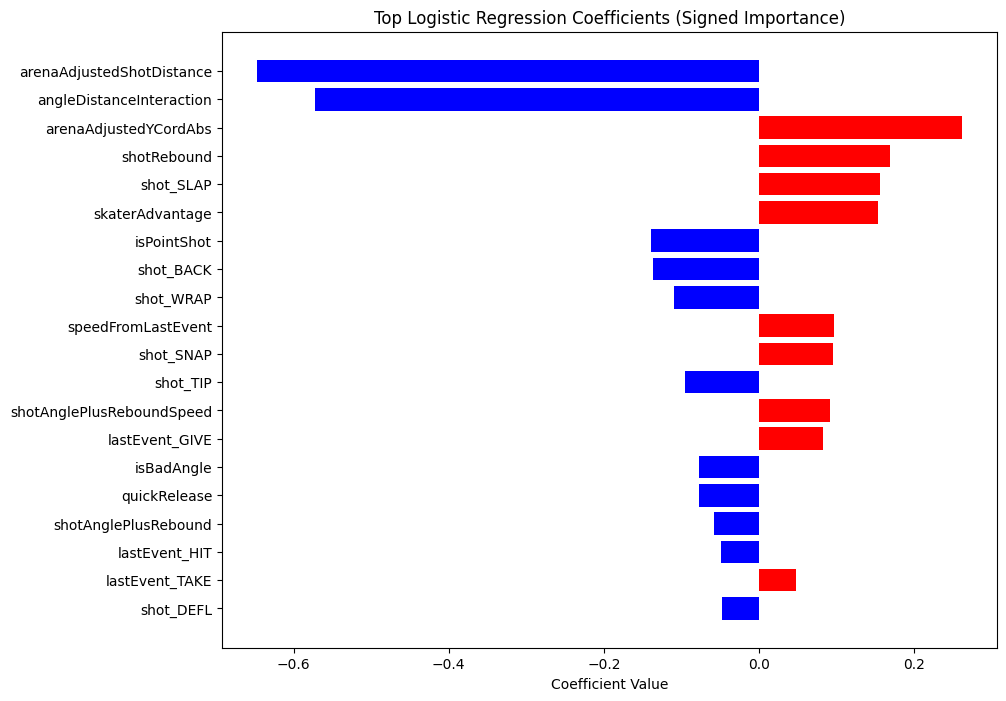

In [31]:
# Get coefficients with names
coef_df = pd.DataFrame({
    "feature": X_train.columns,
    "coef": lr_model.coef_[0]
})

# Sort by absolute value (strongest effects first)
coef_df["abs_coef"] = coef_df["coef"].abs()
coef_df = coef_df.sort_values("abs_coef", ascending=False).head(20)

# Plot
plt.figure(figsize=(10, 8))
colors = coef_df["coef"].apply(lambda x: 'red' if x > 0 else 'blue')
plt.barh(coef_df["feature"], coef_df["coef"], color=colors)
plt.xlabel("Coefficient Value")
plt.title("Top Logistic Regression Coefficients (Signed Importance)")
plt.gca().invert_yaxis()
plt.show()

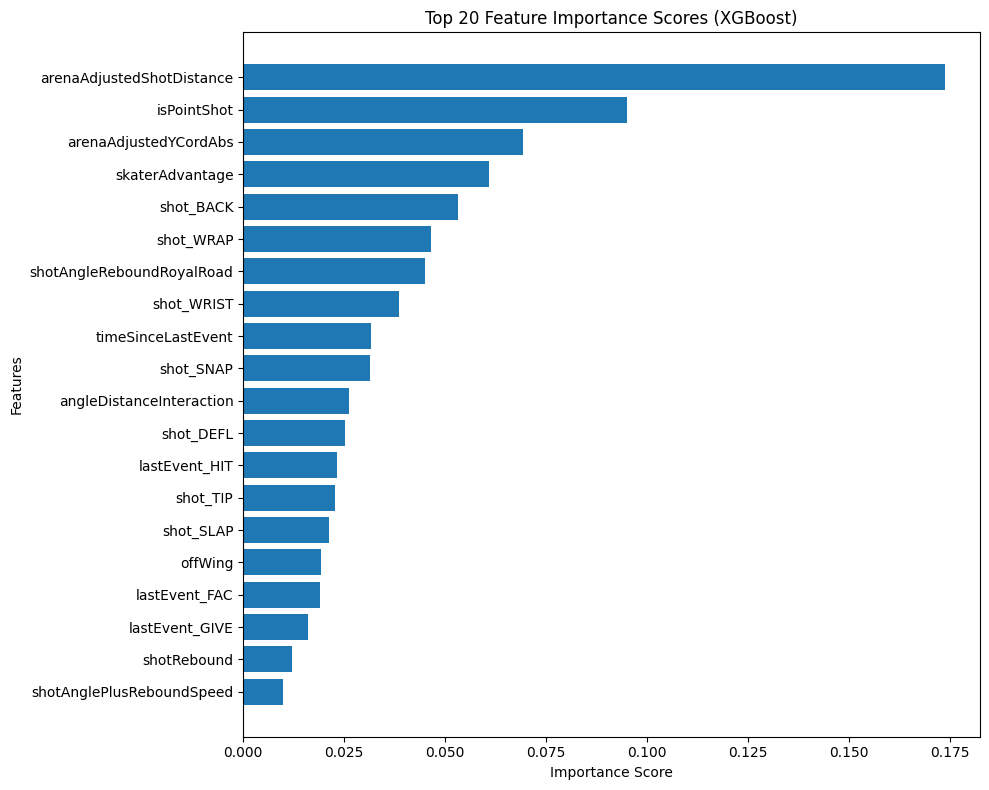


Features for 90% cumulative importance: 28
                      Feature Importance Cumulative_Importance
4   arenaAdjustedShotDistance   0.173729              0.173729
24                isPointShot   0.094925              0.268654
2       arenaAdjustedYCordAbs   0.069298              0.337952
20            skaterAdvantage   0.060798              0.398751
31                  shot_BACK   0.053168              0.451919
36                  shot_WRAP   0.046427              0.498346
9   shotAngleReboundRoyalRoad   0.044921              0.543267
37                 shot_WRIST   0.038685              0.581952
0          timeSinceLastEvent   0.031613              0.613565
34                  shot_SNAP   0.031434              0.644999


In [32]:
feature_importance = xgb_model.feature_importances_
feature_names = X_train.columns.tolist()
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
importance_df = importance_df.sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'][:20], importance_df['Importance'][:20])
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Top 20 Feature Importance Scores (XGBoost)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

importance_df['Cumulative_Importance'] = importance_df['Importance'].cumsum()
selected_features = importance_df[importance_df['Cumulative_Importance'] <= 0.9]
if len(selected_features) < len(importance_df):
    next_feature = importance_df.iloc[len(selected_features)]
    selected_features = pd.concat([selected_features, next_feature.to_frame().T])

print(f"\nFeatures for 90% cumulative importance: {len(selected_features)}")
print(selected_features[['Feature', 'Importance', 'Cumulative_Importance']].head(10))


In [33]:


from sklearn.metrics import precision_recall_curve

# Calibrate models and find optimal thresholds
calibrated_models = {}
optimal_thresholds = {}
calibrated_proba_val = {}
calibrated_proba_test = {}
test_times = {}

for model_name, model in models.items():
    if hasattr(model, 'predict_proba'):
        print(f"\n{model_name}:")
        
        calibrated_model = CalibratedClassifierCV(model, method='isotonic', cv=3)
        calibrated_model.fit(X_train_scaled, y_train)
        calibrated_models[model_name] = calibrated_model
        
        y_val_proba_cal = calibrated_model.predict_proba(X_val_scaled)[:, 1]
        calibrated_proba_val[model_name] = y_val_proba_cal
        
        thresholds = np.arange(0.05, 0.7, 0.01)
        f1_scores = []
        precision_scores = []
        recall_scores = []
        
        for thresh in thresholds:
            y_pred_thresh = (y_val_proba_cal >= thresh).astype(int)
            f1 = f1_score(y_val, y_pred_thresh)
            prec, rec, _, _ = precision_recall_fscore_support(y_val, y_pred_thresh, labels=[1], zero_division=0)
            f1_scores.append(f1)
            precision_scores.append(prec[0] if len(prec) > 0 else 0)
            recall_scores.append(rec[0] if len(rec) > 0 else 0)
        
        optimal_idx = np.argmax(f1_scores)
        optimal_threshold = thresholds[optimal_idx]
        optimal_thresholds[model_name] = optimal_threshold
        
        print(f"  Optimal threshold: {optimal_threshold:.3f}")
        print(f"    F1 on val: {f1_scores[optimal_idx]:.4f}")
        print(f"    Precision on val: {precision_scores[optimal_idx]:.4f}")
        print(f"    Recall on val: {recall_scores[optimal_idx]:.4f}")
        
        default_idx = np.argmin(np.abs(thresholds - 0.5))
        print(f"  Default threshold (0.5):")
        print(f"    F1 on val: {f1_scores[default_idx]:.4f}")
        print(f"    Precision on val: {precision_scores[default_idx]:.4f}")
        print(f"    Recall on val: {recall_scores[default_idx]:.4f}")
        
        if optimal_threshold >= 0.69:
            print(f"  ⚠️  WARNING: Optimal threshold at upper boundary - consider expanding search range")
        elif optimal_threshold <= 0.06:
            print(f"  ⚠️  WARNING: Optimal threshold at lower boundary - consider expanding search range")

test_predictions_optimal = {}
test_predictions_default = {}
test_proba = {}

for model_name, model in models.items():
    start_time = time.time()
    
    if hasattr(model, 'predict_proba'):
        test_proba[model_name] = model.predict_proba(X_test_scaled)
        y_proba_orig = test_proba[model_name][:, 1]
        
        if model_name in calibrated_models:
            y_proba_cal = calibrated_models[model_name].predict_proba(X_test_scaled)[:, 1]
            calibrated_proba_test[model_name] = y_proba_cal
            
            if model_name in optimal_thresholds:
                test_predictions_optimal[model_name] = (y_proba_cal >= optimal_thresholds[model_name]).astype(int)
            else:
                test_predictions_optimal[model_name] = model.predict(X_test_scaled)
            
            test_predictions_default[model_name] = (y_proba_cal >= 0.5).astype(int)
        else:
            test_predictions_optimal[model_name] = model.predict(X_test_scaled)
            test_predictions_default[model_name] = (y_proba_orig >= 0.5).astype(int)
    else:
        test_predictions_optimal[model_name] = model.predict(X_test_scaled)
        test_predictions_default[model_name] = model.predict(X_test_scaled)
    
    test_times[model_name] = (time.time() - start_time) * 1000

# Evaluate with optimal threshold and calibrated probabilities
results = []

for model_name in models.keys():
    y_pred_opt = test_predictions_optimal[model_name]
    
    # Detailed confusion matrix analysis
    cm = confusion_matrix(y_test, y_pred_opt)
    tn, fp, fn, tp = cm.ravel()
    
    print(f"\n{model_name} - Confusion Matrix (threshold={optimal_thresholds.get(model_name, 0.5):.3f}):")
    print(f"  True Negatives (TN):  {tn:6d} - Correctly predicted non-goals")
    print(f"  False Positives (FP): {fp:6d} - Predicted goal but wasn't (Type I error)")
    print(f"  False Negatives (FN): {fn:6d} - Missed goals (Type II error)")
    print(f"  True Positives (TP):  {tp:6d} - Correctly predicted goals")
    print(f"  Total: {tn+fp+fn+tp}")
    
    # Calculate rates
    total_negatives = tn + fp
    total_positives = fn + tp
    print(f"\n  Error Analysis:")
    print(f"    False Positive Rate: {fp/(fp+tn):.4f} ({fp/(fp+tn)*100:.1f}% of non-goals incorrectly flagged)")
    print(f"    False Negative Rate: {fn/(fn+tp):.4f} ({fn/(fn+tp)*100:.1f}% of goals missed)")
    print(f"    Total Errors: {fp+fn} out of {len(y_test)} ({100*(fp+fn)/len(y_test):.2f}%)")
    
    # Per-class metrics with optimal threshold
    precision_opt, recall_opt, f1_opt, support = precision_recall_fscore_support(
        y_test, y_pred_opt, labels=[0, 1], zero_division=0
    )
    
    # Overall metrics
    accuracy_opt = accuracy_score(y_test, y_pred_opt)
    f1_weighted_opt = f1_score(y_test, y_pred_opt, average='weighted', zero_division=0)
    
    # Use calibrated probabilities if available, otherwise original
    if model_name in calibrated_proba_test:
        y_proba = calibrated_proba_test[model_name]
        proba_source = "calibrated"
    elif model_name in test_proba:
        y_proba = test_proba[model_name][:, 1]
        proba_source = "original"
    else:
        y_proba = None
        proba_source = None
    
    if y_proba is not None:
        roc_auc = roc_auc_score(y_test, y_proba)
        brier = brier_score_loss(y_test, y_proba)
        if model_name in calibrated_proba_test:
            logloss = log_loss(y_test, calibrated_models[model_name].predict_proba(X_test_scaled))
        else:
            logloss = log_loss(y_test, test_proba[model_name])
    else:
        roc_auc = None
        brier = None
        logloss = None
    
    results.append({
        'Model': model_name,
        'Threshold': optimal_thresholds.get(model_name, 0.5),
        'ROC-AUC': roc_auc,
        'F1-Weighted': f1_weighted_opt,
        'F1-Goal': f1_opt[1],
        'Goal-Recall': recall_opt[1],
        'Goal-Precision': precision_opt[1],
        'Accuracy': accuracy_opt,
        'Brier Score': brier,
        'Log Loss': logloss,
        'FP Rate': fp/(fp+tn) if (fp+tn) > 0 else 0,
        'FN Rate': fn/(fn+tp) if (fn+tp) > 0 else 0,
        'Test Time (ms)': test_times[model_name],
        'Proba Source': proba_source
    })

results_df = pd.DataFrame(results)
print(results_df[['Model', 'Threshold', 'ROC-AUC', 'F1-Goal', 'Goal-Recall', 
                  'Goal-Precision', 'FP Rate', 'FN Rate', 'Accuracy']].to_string(index=False))
for idx, row in results_df.iterrows():
    print(f"\n{row['Model']} (threshold={row['Threshold']:.3f}, {row['Proba Source']} probabilities):")
    print(f"  ROC-AUC: {row['ROC-AUC']:.4f} (primary metric)")
    print(f"  Goal Recall: {row['Goal-Recall']:.4f} ({row['Goal-Recall']*100:.1f}% of goals caught)")
    print(f"  Goal Precision: {row['Goal-Precision']:.4f} ({row['Goal-Precision']*100:.1f}% of goal predictions correct)")
    print(f"  Goal F1: {row['F1-Goal']:.4f}")
    print(f"  False Positive Rate: {row['FP Rate']:.4f} ({row['FP Rate']*100:.1f}% false alarms)")
    print(f"  False Negative Rate: {row['FN Rate']:.4f} ({row['FN Rate']*100:.1f}% missed goals)")
    print(f"  Accuracy: {row['Accuracy']:.4f} (less important for imbalanced data)")
    if row['Brier Score'] is not None:
        print(f"  Brier Score: {row['Brier Score']:.4f} (lower is better, calibrated should improve this)")



Logistic Regression:
  Optimal threshold: 0.130
    F1 on val: 0.2552
    Precision on val: 0.1868
    Recall on val: 0.4028
  Default threshold (0.5):
    F1 on val: 0.0003
    Precision on val: 0.4286
    Recall on val: 0.0001

XGBoost:
  Optimal threshold: 0.140
    F1 on val: 0.2773
    Precision on val: 0.2158
    Recall on val: 0.3877
  Default threshold (0.5):
    F1 on val: 0.0169
    Precision on val: 0.5682
    Recall on val: 0.0086

Logistic Regression - Confusion Matrix (threshold=0.130):
  True Negatives (TN):  144087 - Correctly predicted non-goals
  False Positives (FP):  20266 - Predicted goal but wasn't (Type I error)
  False Negatives (FN):   6917 - Missed goals (Type II error)
  True Positives (TP):    4713 - Correctly predicted goals
  Total: 175983

  Error Analysis:
    False Positive Rate: 0.1233 (12.3% of non-goals incorrectly flagged)
    False Negative Rate: 0.5948 (59.5% of goals missed)
    Total Errors: 27183 out of 175983 (15.45%)

XGBoost - Confusion Mat

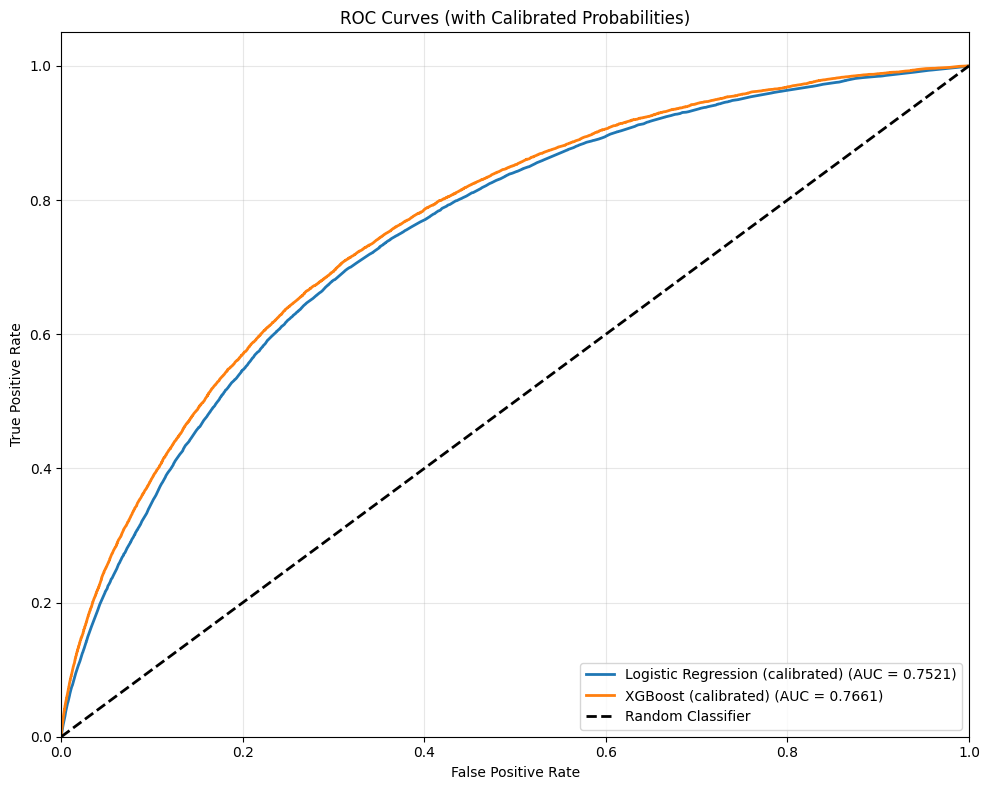

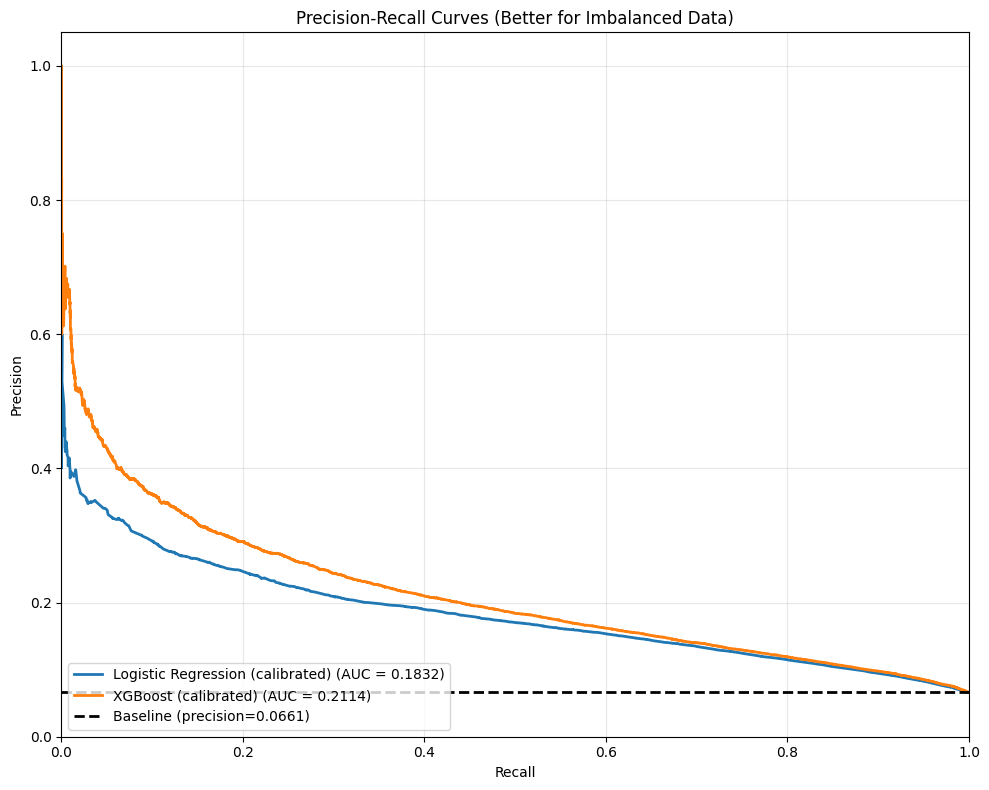

In [34]:
# ROC Curves
plt.figure(figsize=(10, 8))
for model_name in models.keys():
    # Use calibrated probabilities if available
    if model_name in calibrated_proba_test:
        y_proba = calibrated_proba_test[model_name]
        label_suffix = " (calibrated)"
    elif model_name in test_proba:
        y_proba = test_proba[model_name][:, 1]
        label_suffix = ""
    else:
        continue
    
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name}{label_suffix} (AUC = {roc_auc:.4f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (with Calibrated Probabilities)')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Precision-Recall Curves (better for imbalanced data)
plt.figure(figsize=(10, 8))
for model_name in models.keys():
    # Use calibrated probabilities if available
    if model_name in calibrated_proba_test:
        y_proba = calibrated_proba_test[model_name]
        label_suffix = " (calibrated)"
    elif model_name in test_proba:
        y_proba = test_proba[model_name][:, 1]
        label_suffix = ""
    else:
        continue
    
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f'{model_name}{label_suffix} (AUC = {pr_auc:.4f})', linewidth=2)

# Baseline: predict all as positive class
baseline_precision = y_test.mean()
plt.axhline(y=baseline_precision, color='k', linestyle='--', linewidth=2, 
            label=f'Baseline (precision={baseline_precision:.4f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves (Better for Imbalanced Data)')
plt.legend(loc="lower left")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



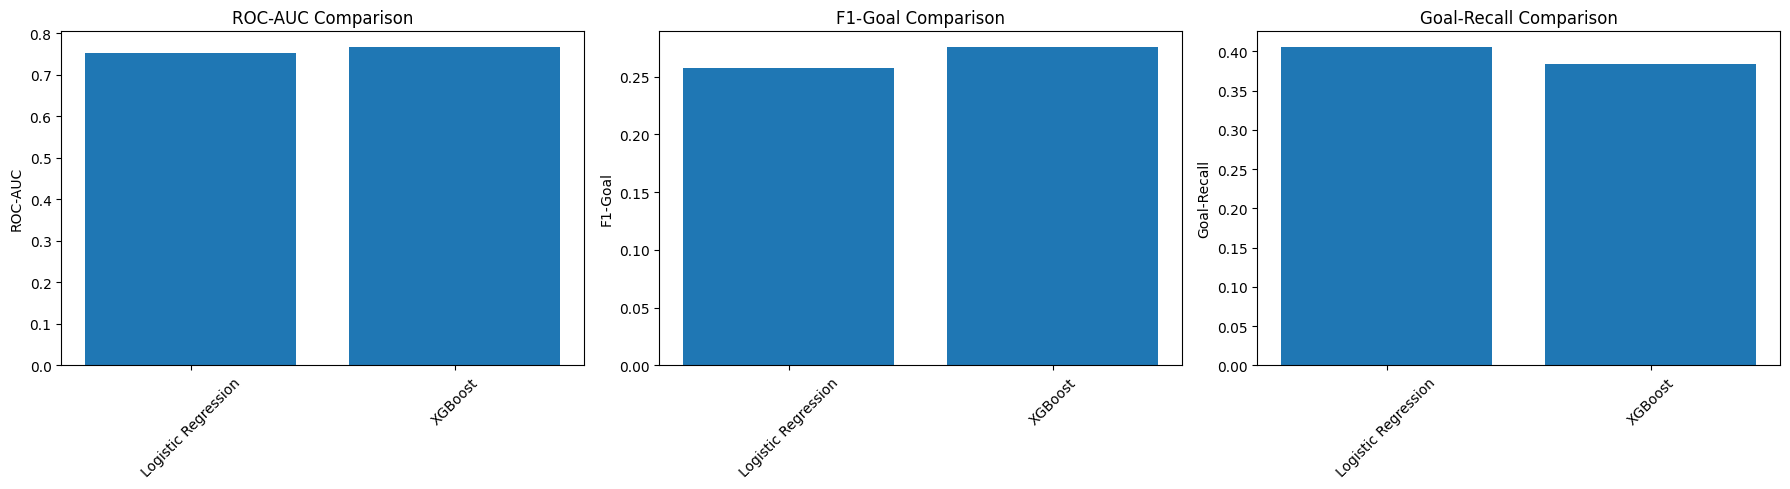


Best model by ROC-AUC: XGBoost
  ROC-AUC: 0.7661
  Goal Recall: 0.3840
  Goal F1: 0.2755


In [35]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics = ['ROC-AUC', 'F1-Goal', 'Goal-Recall']
for idx, metric in enumerate(metrics):
    axes[idx].bar(results_df['Model'], results_df[metric])
    axes[idx].set_ylabel(metric)
    axes[idx].set_title(f'{metric} Comparison')
    axes[idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Select best model by ROC-AUC (primary metric for imbalanced data)
best_model_name = results_df.loc[results_df['ROC-AUC'].idxmax(), 'Model']
print(f"\nBest model by ROC-AUC: {best_model_name}")
print(f"  ROC-AUC: {results_df.loc[results_df['ROC-AUC'].idxmax(), 'ROC-AUC']:.4f}")
print(f"  Goal Recall: {results_df.loc[results_df['ROC-AUC'].idxmax(), 'Goal-Recall']:.4f}")
print(f"  Goal F1: {results_df.loc[results_df['ROC-AUC'].idxmax(), 'F1-Goal']:.4f}")


In [36]:
best_model = models[best_model_name]

if hasattr(best_model, 'coef_'):
    l2_penalty = np.sum(best_model.coef_**2)
    print(f"L2 penalty (sum of squared coefficients): {l2_penalty:.4f}")

ridge_model = Ridge(alpha=0.5, random_state=42)
ridge_model.fit(X_train_scaled, y_train)
ridge_pred = ridge_model.predict(X_test_scaled)
ridge_pred_binary = (ridge_pred > 0.5).astype(int)
ridge_mse = np.mean((y_test - ridge_pred)**2)
print(f"Ridge Regression MSE: {ridge_mse:.4f}")


Ridge Regression MSE: 0.0583


Calibration Comparison for XGBoost:
  Original Brier Score: 0.1933
  Calibrated Brier Score: 0.0570
  Improvement: 0.1363


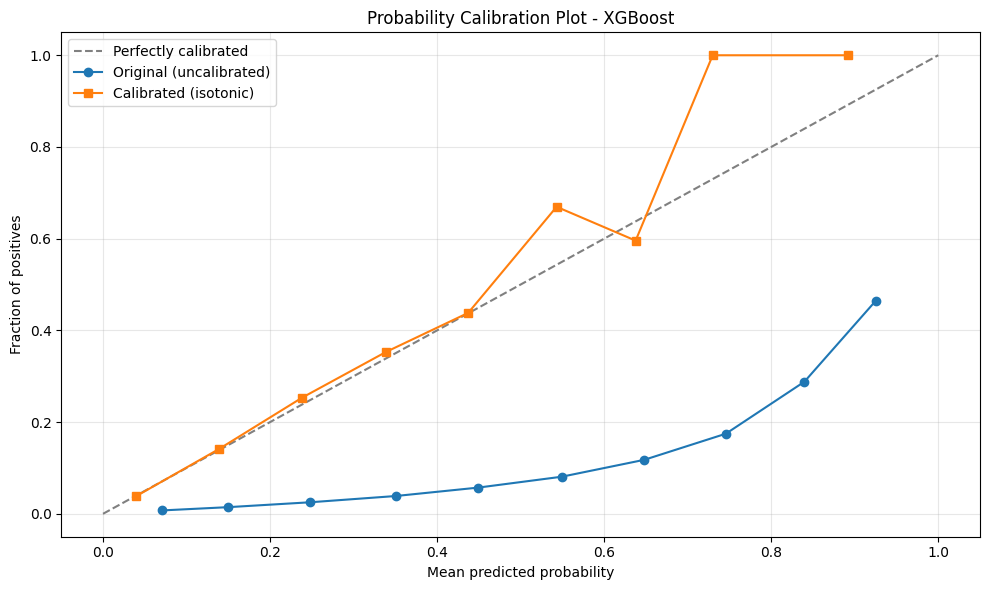

In [38]:
# Calibration comparison (using already-calibrated models from Cell 16)
if best_model_name in test_proba:
    original_proba = test_proba[best_model_name][:, 1]
    
    if best_model_name in calibrated_proba_test:
        calibrated_proba_pos = calibrated_proba_test[best_model_name]
        
        print(f"Calibration Comparison for {best_model_name}:")
        print(f"  Original Brier Score: {brier_score_loss(y_test, original_proba):.4f}")
        print(f"  Calibrated Brier Score: {brier_score_loss(y_test, calibrated_proba_pos):.4f}")
        print(f"  Improvement: {brier_score_loss(y_test, original_proba) - brier_score_loss(y_test, calibrated_proba_pos):.4f}")
        
        from sklearn.calibration import calibration_curve
        
        prob_true_orig, prob_pred_orig = calibration_curve(y_test, original_proba, n_bins=10)
        prob_true_cal, prob_pred_cal = calibration_curve(y_test, calibrated_proba_pos, n_bins=10)
        
        plt.figure(figsize=(10, 6))
        plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated', color='gray')
        plt.plot(prob_pred_orig, prob_true_orig, marker='o', label='Original (uncalibrated)')
        plt.plot(prob_pred_cal, prob_true_cal, marker='s', label='Calibrated (isotonic)')
        plt.xlabel('Mean predicted probability')
        plt.ylabel('Fraction of positives')
        plt.title(f'Probability Calibration Plot - {best_model_name}')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    else:
        print(f"Note: {best_model_name} probabilities were not calibrated in Cell 16")


In [18]:
if best_model_name == 'XGBoost':
    explainer = shap.TreeExplainer(best_model)
    shap_values = explainer.shap_values(X_test_scaled[:1000])
    
    if isinstance(shap_values, list):
        shap_values = shap_values[1]
    
    shap.summary_plot(shap_values, X_test_scaled[:1000], feature_names=X_train.columns.tolist(), 
                     max_display=20, show=False)
    plt.tight_layout()
    plt.show()
    
    shap_values_mean = np.abs(shap_values).mean(0)
    feature_importance_shap = pd.DataFrame({
        'Feature': X_train.columns.tolist(),
        'SHAP Importance': shap_values_mean
    }).sort_values('SHAP Importance', ascending=False)
    
    print("\nTop 10 features by SHAP importance:")
    print(feature_importance_shap.head(10))
else:
    print("SHAP analysis skipped (best model is not tree-based)")


NameError: name 'best_model' is not defined

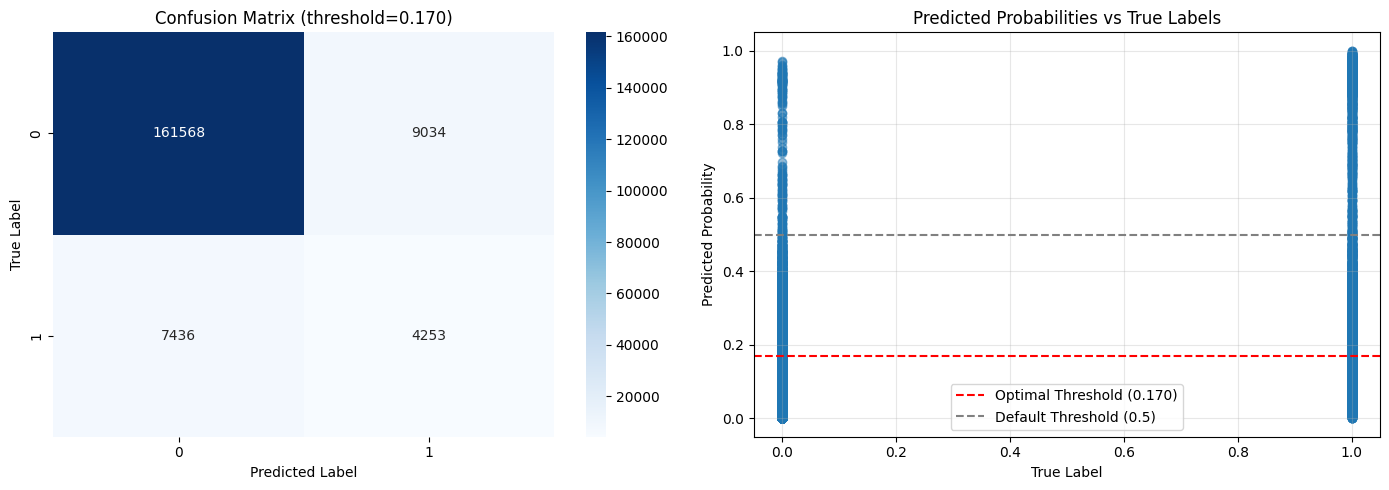


XGBoost - Threshold: 0.170 (calibrated probabilities):
  True Negatives:  161568
  False Positives:   9034 (5.3% false alarm rate)
  False Negatives:   7436 (63.6% missed goals)
  True Positives:    4253
  ROC-AUC: 0.8179
  Goal Recall: 0.3638 (36.4% of goals caught)
  Goal Precision: 0.3201 (32.0% of goal predictions correct)
  Goal F1: 0.3406
  Accuracy: 0.9096
  F1-Score (weighted): 0.9123
  Brier Score: 0.0498
  Log Loss: 0.1872


In [ ]:
if best_model_name in test_proba:
    y_pred_best = test_predictions_optimal[best_model_name]
    # Use calibrated probabilities if available
    if best_model_name in calibrated_proba_test:
        y_proba_best = calibrated_proba_test[best_model_name]
        proba_label = "calibrated"
    else:
        y_proba_best = test_proba[best_model_name][:, 1]
        proba_label = "original"
    opt_threshold = optimal_thresholds.get(best_model_name, 0.5)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    cm = confusion_matrix(y_test, y_pred_best)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
    axes[0].set_title(f'Confusion Matrix (threshold={opt_threshold:.3f})')
    axes[0].set_ylabel('True Label')
    axes[0].set_xlabel('Predicted Label')
    
    axes[1].scatter(y_test, y_proba_best, alpha=0.5)
    axes[1].axhline(y=opt_threshold, color='r', linestyle='--', label=f'Optimal Threshold ({opt_threshold:.3f})')
    axes[1].axhline(y=0.5, color='gray', linestyle='--', label='Default Threshold (0.5)')
    axes[1].set_xlabel('True Label')
    axes[1].set_ylabel('Predicted Probability')
    axes[1].set_title('Predicted Probabilities vs True Labels')
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Per-class metrics
    precision, recall, f1, support = precision_recall_fscore_support(
        y_test, y_pred_best, labels=[0, 1], zero_division=0
    )
    
    # Confusion matrix details
    cm = confusion_matrix(y_test, y_pred_best)
    tn, fp, fn, tp = cm.ravel()
    
    print(f"\n{best_model_name} - Threshold: {opt_threshold:.3f} ({proba_label} probabilities):")
    print(f"  True Negatives:  {tn:6d}")
    print(f"  False Positives: {fp:6d} ({fp/(fp+tn)*100:.1f}% false alarm rate)")
    print(f"  False Negatives: {fn:6d} ({fn/(fn+tp)*100:.1f}% missed goals)")
    print(f"  True Positives:  {tp:6d}")
    print(f"  ROC-AUC: {roc_auc_score(y_test, y_proba_best):.4f}")
    print(f"  Goal Recall: {recall[1]:.4f} ({recall[1]*100:.1f}% of goals caught)")
    print(f"  Goal Precision: {precision[1]:.4f} ({precision[1]*100:.1f}% of goal predictions correct)")
    print(f"  Goal F1: {f1[1]:.4f}")
    print(f"  Accuracy: {accuracy_score(y_test, y_pred_best):.4f}")
    print(f"  F1-Score (weighted): {f1_score(y_test, y_pred_best, average='weighted'):.4f}")
    print(f"  Brier Score: {brier_score_loss(y_test, y_proba_best):.4f}")
    if best_model_name in calibrated_proba_test:
        print(f"  Log Loss: {log_loss(y_test, calibrated_models[best_model_name].predict_proba(X_test_scaled)):.4f}")
    else:
        print(f"  Log Loss: {log_loss(y_test, test_proba[best_model_name]):.4f}")


In [ ]:
best_row = results_df[results_df['Model'] == best_model_name].iloc[0]
print(f"\nBest model: {best_model_name}")
print(f"  ROC-AUC: {best_row['ROC-AUC']:.4f}")
print(f"  Goal Recall: {best_row['Goal-Recall']:.4f} ({best_row['Goal-Recall']*100:.1f}% of goals caught)")
print(f"  Goal F1: {best_row['F1-Goal']:.4f}")
print(f"  Goal Precision: {best_row['Goal-Precision']:.4f}")
print(f"  Optimal Threshold: {best_row['Threshold']:.3f}")
print(f"  Accuracy: {best_row['Accuracy']:.4f}")
print(f"  F1-Score (weighted): {best_row['F1-Weighted']:.4f}")
print(f"  Brier Score: {best_row['Brier Score']:.4f}")
print(f"Total models evaluated: {len(models)}")
print(f"Training time range: {min(training_times.values()):.2f} - {max(training_times.values()):.2f} ms")



Best model: XGBoost
  ROC-AUC: 0.8179
  Goal Recall: 0.3638 (36.4% of goals caught)
  Goal F1: 0.3406
  Goal Precision: 0.3201
  Optimal Threshold: 0.170
  Accuracy: 0.9096
  F1-Score (weighted): 0.9123
  Brier Score: 0.0498
Total models evaluated: 2
Training time range: 10890.21 - 26830.38 ms
